(array([31579., 12864., 10295.,  8404.,  7456.,  6736.,  6257.,  5869.,
         5406.,  5134.]),
 array([1.75738082e-12, 9.99998200e-02, 1.99999640e-01, 2.99999460e-01,
        3.99999280e-01, 4.99999100e-01, 5.99998920e-01, 6.99998740e-01,
        7.99998560e-01, 8.99998380e-01, 9.99998200e-01]),
 <a list of 10 Patch objects>)

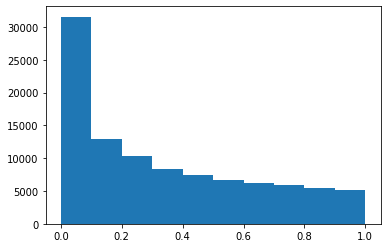

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

S = 100000
x = np.random.uniform(-1,1,size=S)
y = x**2
plt.hist(y)

In [2]:
import scipy.stats

n = 10
theta = y
k_ = scipy.stats.binom.rvs(n, theta)

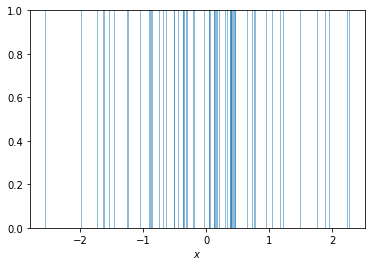

In [3]:
# construct data set by sampling from Gaussian
np.random.seed(0)
D = scipy.stats.norm.rvs(size=100)

# plot as bar chart
plt.bar(D, height=1, width=0.01, alpha=0.5);
ax = plt.gca()
ax.set_xlabel('$x$');
ax.set_ylim(0,1);

In [4]:
def log_like(params, D):
    mean, log_sigma = params
    sigma = np.exp(log_sigma) # prevents sigma < 0
    # likelihood is same function as sampling process for D: likelihood principle
    return np.sum(scipy.stats.norm.logpdf(D, loc=mean, scale=sigma))

def log_prior(params):
    mean, log_sigma = params
    sigma = np.exp(log_sigma)
    return 1/sigma # non-informative prior = Jeffreys' priors

def log_posterior(params, D):
    return log_like(params, D) + log_prior(params)

# some initial guess, use log of sigma to prevent sigma < 0
params = (0.5, np.log(0.2))

In [5]:
import emcee, corner

# create a small ball around the MLE the initialize each walker 
nwalkers, ndim = 30, 2
pos = params + 1e-3 * np.random.randn(nwalkers, ndim)

# run emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(D,))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:21<00:00, 237.85it/s]


In [7]:
print(params)
print(pos)

(0.5, -1.6094379124341003)
[[ 0.50188315 -1.61078567]
 [ 0.49872952 -1.60846852]
 [ 0.49882688 -1.60749429]
 [ 0.49958638 -1.61018537]
 [ 0.50192294 -1.6079574 ]
 [ 0.50186756 -1.60853187]
 [ 0.49913877 -1.60752785]
 [ 0.499732   -1.60863546]
 [ 0.50094725 -1.60959292]
 [ 0.50061408 -1.60851571]
 [ 0.50037643 -1.61053731]
 [ 0.50029824 -1.60811153]
 [ 0.49930543 -1.60958755]
 [ 0.49956485 -1.60758865]
 [ 0.50067229 -1.60903045]
 [ 0.49923008 -1.60889866]
 [ 0.49932567 -1.60940608]
 [ 0.49936415 -1.60876148]
 [ 0.50057659 -1.60964621]
 [ 0.50039601 -1.61053097]
 [ 0.49850874 -1.60899852]
 [ 0.50016667 -1.60880288]
 [ 0.50238314 -1.60849343]
 [ 0.49908718 -1.6083209 ]
 [ 0.49868409 -1.6098995 ]
 [ 0.49993176 -1.60772457]
 [ 0.49925525 -1.61026435]
 [ 0.49990155 -1.61010139]
 [ 0.50112664 -1.61051784]
 [ 0.49885253 -1.60987573]]


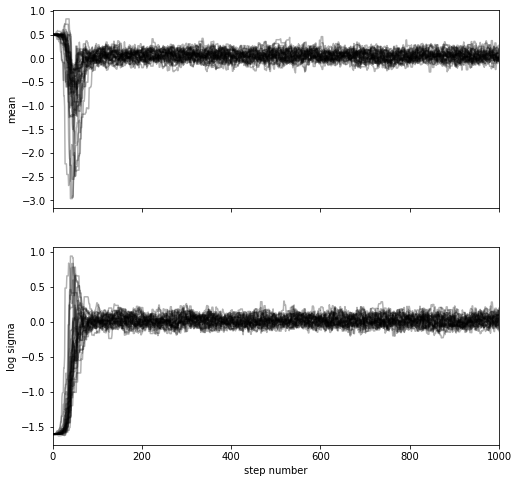

In [8]:
samples = sampler.get_chain()

fig, axes = plt.subplots(ndim, sharex=True, figsize=(8,8))
labels = ["mean", "log sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 1000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[27.64930888 41.94838346]


In [10]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(7350, 2)


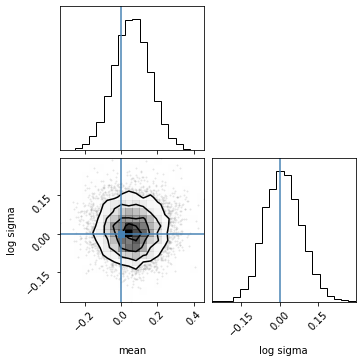

In [11]:
m_true, ls_true = 0, 0
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, ls_true]
);

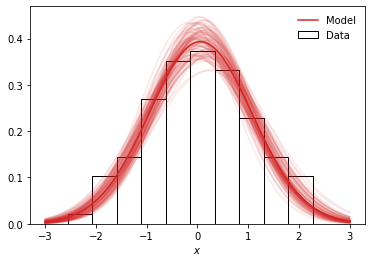

In [12]:
x = np.linspace(-3,3,100)
plt.hist(D, bins=10, density=True, label='Data', fc='None', ec='k')

# take mean of samples as a valid guess for the most like model
params = flat_samples[:,0].mean(), np.exp(flat_samples[:,1].mean())
plt.plot(x, scipy.stats.norm.pdf(x, *params), label='Model', color='tab:red')

# plot random draw from the posterior chain as PPD
for k,i in enumerate(np.random.randint(0, high=len(flat_samples), size=100)):
    mu, sigma = flat_samples[i][0], np.exp(flat_samples[i][1])
    plt.plot(x, scipy.stats.norm.pdf(x, mu,sigma), c='tab:red', alpha=0.1)
    
plt.xlabel('$x$');
plt.legend(frameon=False);